#### This notebook provides user-friendly code for several speech processing tasks: text-to-speech (TTS), speech-to-text (STT), speaker diarization, and finetuning a TTS model. The relevant Python scripts are located in the utils folder.

#### To get started, we recommend using a Poetry environment for managing dependencies. For optimal performance, it is advisable to have an NVIDIA GPU with CUDA drivers installed. However, if a GPU is not available, you can still run TTS and STT at a reasonable speed on a CPU. Additionally, some implementations, such as whispercpp and ONNX, offer hardware acceleration for CPU usage.
## I) One shot cloning with TTS


In [ ]:
from utils.gradio_helpers import download_model_hf

## Download model from HF if not already download, customize the paths
where_to_dl="xtts_v2"
model_to_dl="coqui/XTTS-v2"
download_model_hf(where_to_dl,model_to_dl) 

In [ ]:
from utils.tts_pipeline import load_model

## Load the model
model=load_model(where_to_dl)

import torch 
## Send to the GPU if cuda is avaible
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
if device == "cuda":
    print("Using GPU")
else:
    print("Using CPU")

In [ ]:
from utils.tts_pipeline import generation,load_speaker, save_speaker

## We are gonna do the voice cloning using one shot method
##Your audio path you want to clone, using a high quality audio between 6-12 seconds is recommended
## Here I will use audio from https://huggingface.co/coqui/XTTS-v2/tree/main/samples (wav, mp3 ... are working)

audio_path="samples_en_sample.wav" 

## First we compute the speaker_embedding and gpt_cond_latent

gpt_cond_latent, speaker_embedding = model.get_conditioning_latents(audio_path=audio_path)

## You can save the gpt_cond_latent, speaker_embedding to load it faster using the following code

# save_speaker(model,audio_path,"your\path\to\save")
# gpt_cond_latent, speaker_embedding = load_speaker("your\path\to\save")

### Generation Function Arguments

The generation function takes a lot of arguments. Here is a detailed list:

#### Required Arguments

- **model**: 
  - Must be `xtts_v2` or a fine-tuning of `xtts_v2`.
  
- **text**: 
  - The text expected in the audio.

- **language**: 
  - The language of the text. 
  - This argument doesn't depend on the input audio and can be chosen among 17 languages:
    - English (`en`)
    - Spanish (`es`)
    - French (`fr`)
    - German (`de`)
    - Italian (`it`)
    - Portuguese (`pt`)
    - Polish (`pl`)
    - Turkish (`tr`)
    - Russian (`ru`)
    - Dutch (`nl`)
    - Czech (`cs`)
    - Arabic (`ar`)
    - Chinese (`zh-cn`)
    - Japanese (`ja`)
    - Hungarian (`hu`)
    - Korean (`ko`)
    - Hindi (`hi`)

- **gpt_cond_latent**:
  - The gpt_cond_latent from the input audio
  
- **speaker_embedding**:
  - The speaker_embedding from the input audio

- **output_path**
  - Where to save the generated audio

### Optional Arguments

- **temperature**: 
  - The softmax temperature of the autoregressive model.
  - Defaults to `0.65`.

- **speed**: 
  - The speed rate of the generated audio.
  - Set it between `0` and `2`.
  - Default is `1.0`.

- **Repetition Penalty**: 
  - A penalty that prevents the autoregressive decoder from repeating itself during decoding.
  - Can be used to reduce the incidence of long silences or “uhhhhhhs”, etc.
  - Defaults to `2.0`.

- **Top K**: 
  - Lower values mean the decoder produces more “likely” (aka boring) outputs.
  - Defaults to `50`.

In [ ]:
import IPython
## First audio generated in english
generation(model,"My first audio generated","en",gpt_cond_latent,speaker_embedding,"test.wav")
IPython.display.Audio("test.wav")

In [ ]:
## You can also do it another language, using french for example
generation(model,"Mon premier audio en français","fr",gpt_cond_latent,speaker_embedding,"test_fr.wav")
IPython.display.Audio("test_fr.wav")

In [ ]:
## You can play with other parameters (more user friendly using the Gradio App)
dict_args={"speed":0.7,"top_k":80,"temperature":0.8}
generation(model,"My second audio generated using different parameters","en",gpt_cond_latent,speaker_embedding,"test_2.wav",dict_args)
IPython.display.Audio("test_2.wav")

In [ ]:
## Dump the model to save the vram
import gc
gc.collect()
torch.cuda.empty_cache()
del model

## II) Speech to Text & Speaker Diarization
#### For the speech to text model we will use faster-whisper-large-v3, a faster implementation off whisper (if you are using a cpu you can use a smaller model). For all the notebook examples I will use a truncated podcast with Elon Musk(https://www.youtube.com/watch?v=JN3KPFbWCy8).

In [ ]:
model_path_stt="faster_whisper"
download_model_hf(model_path_stt,"Systran/faster-whisper-large-v3")

## stt Function Arguments

The `stt` function is used for converting speech to text. Here is a detailed list of its arguments:

### Required Arguments

- **model_path**: 
  - A string indicating the path to the model to be used for transcription.

- **audio_file**: 
  - A string specifying the path to the audio file to be transcribed.

- **lang**: 
  - A string representing the language of the audio. Whisper supports even more languages than tts.

### Optional Arguments

- **device**: 
  - Specifies the device to run the model on. Cuda will be faster
  - Defaults to `"cuda"`.
  - Can also be set to `"cpu"` if CUDA is not available.

- **batch_size**: 
  - An integer indicating the number of audio samples to process in each batch. Lower if you don't have a lot of VRAM
  - Defaults to `12`.

- **compute_type**: 
  - Specifies the precision type for computations.
  - Defaults to `"float16"`.
  - Can be changed to `"int8"` for lower precision at the cost of performance.


In [ ]:
from utils.stt_pipeline import stt, stt_string
audio_stt="elo_musk_podcast.wav"
lang="en"
res=stt(model_path_stt,audio_stt,lang,device,batch_size= 12,compute_type = "int8") #you lower batch_size if you have cuda oom errors
print()
print(stt_string(res))

#### For the diarization model, we will need a hf token (you can grabe one here : https://huggingface.co/settings/tokens). Without GPU the diarization is relatively slow (even with the GPU).

## Diarization Function Arguments

The `diarization` function is used for speaker diarization in audio files. Here is a detailed list of its arguments:

### Required Arguments

- **model_path**: 
  - A string indicating the path to the diarization model to be used.

- **audio_file**: 
  - A string specifying the path to the audio file for diarization.

- **token_hf**: 
  - A string representing the token for authentication with the Hugging Face API or service.

### Optional Arguments

- **device**: 
  - Specifies the device to run the model on.
  - Defaults to `"cuda"`.
  - Can also be set to `"cpu"` if CUDA is not available.

- **embedding_batch_size**: 
  - An integer indicating the number of audio segments to process in each batch during embedding computation.
  - Defaults to `12`.

- **segmentation_batch_size**: 
  - An integer indicating the number of audio segments to process in each batch during segmentation.
  - Defaults to `12`.

- **num speakers**:
  - Number of speakers in the audio (the diarization will be more precise if provided)
  - Default to -1 (same as unknown)
  - This parameters can improve a lot the diarization

### Return

- **Annotation**:
  - The function returns an `Pyannote.Annotation` object, which contains information about the different speakers identified in the audio file.

In [ ]:
from utils.stt_pipeline import diarization
HF_token="" #Your HF token
res_dia=diarization("pyannote/speaker-diarization-3.1","elo_musk_podcast.wav",token_hf=HF_token,device=device,embedding_batch_size=12,segmentation_batch_size=12)
res_dia

#### matching_stt_dia, stt_dia_str are homemade functions to match the transcriptiona and diarization. It's possible to improve them using punctuation analysis, LLMs ...

In [ ]:
from utils.stt_pipeline import matching_stt_dia, stt_dia_str

res_stt_dia=matching_stt_dia(res,res_dia)
print(stt_dia_str(res_stt_dia))

: 

## III) Finetuning TTS model
#### This section will only works with GPU (nvidia).
#### Everything is based from here https://docs.coqui.ai/en/latest/models/xtts.html#training
 - I) Dataset creation
 - II) Training
 - III) Inference


### I) Dataset Creation
#### See this post to know globally how the training dataset will be build (https://github.com/coqui-ai/TTS/wiki/What-makes-a-good-TTS-dataset), but keep in mind that audios with enough speech (between 20min - 2 hours for one speaker), no background noises (music, laughs) and good quality will always have better results.
#### The audio in the training will be between 1 & 15 seconds, so the trick will be to split the audios you want to use for training. The dataset need to be in Coqui  Style Dataset which is :
- The name of an audio file
- The text for that file. E.g., "Jane eyre by Charlotte Bronte. Chapter 1."
- The speaker. E.g., "speaker_01". (optional)
- The tone.  E.g., "neutral". (optional)

torchvision is not available - cannot save figures


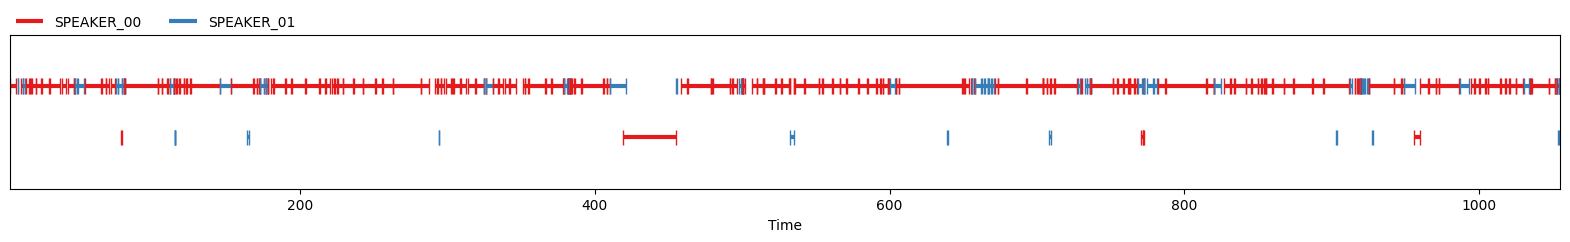

In [1]:
from utils.finetuning import suppress_overlaps_and_blanks
HF_token="" #Your HF token
wave,sp_rate,res_dia=suppress_overlaps_and_blanks(["youtube_wav.wav"],HF_token,num_speakers=2) #if memory errors you can, lower embedding_batch_size=12,segmentation_batch_size=12 in arguments
res_dia

#### Now let's choose speaker(s) we want to clone to create our training dataset.

In [2]:
from utils.finetuning import get_matching_audio_speakers, create_audio
lst_speakers=["SPEAKER_01"] #Speaker you want to clone
path_stt_model="faster_whisper" #path for the stt model use (must be a faster whisper model)
lang="fr"

## if you dont have enough memory you can lower embedding_batch_size=12,segmentation_batch_size=12,stt_batch_size=12

datframe_speaker=get_matching_audio_speakers(wave,sp_rate,lst_speakers,HF_token,path_stt_model,lang,embedding_batch_size=12,segmentation_batch_size=12,stt_batch_size=12,num_speakers=2)

Lightning automatically upgraded your loaded checkpoint from v1.5.4 to v2.4.0. To apply the upgrade to your files permanently, run `python -m pytorch_lightning.utilities.upgrade_checkpoint c:\Users\Greg\AppData\Local\pypoetry\Cache\virtualenvs\voice-cloner-dUKFIqf--py3.10\lib\site-packages\faster_whisper\assets\pyannote_vad_model.bin`


Model was trained with pyannote.audio 0.0.1, yours is 3.3.1. Bad things might happen unless you revert pyannote.audio to 0.x.
Model was trained with torch 1.10.0+cu102, yours is 2.2.0+cu118. Bad things might happen unless you revert torch to 1.x.


#### Create the dataset in the right format (create the directory, metadata.csv & wavs files)

In [3]:
from utils.finetuning import create_dataset
## Path to where create the dataset
path_dataset="dataset/"

## Max length for the audio size (I highly recommend to not play too much)
max_audio_length=15

create_dataset(wave,sp_rate,path_dataset,datframe_speaker,max_length=max_audio_length)

'dataset/'

#### Too improve quality of the training set (to improve finetuning) you can check these ressources. https://github.com/coqui-ai/TTS/tree/dev/notebooks/dataset_analysis .
### II) Training
#### Most of parameters are recommended by https://docs.coqui.ai/
#### You can modify all parameters in the utils/finetuning.py file but you need to know what you are doing.
#### BATCH_SIZE
- **Definition**: The `BATCH_SIZE` parameter defines the number of samples that are processed together in a single forward and backward pass during training.
- **Value**: Default value `3`
- **Explanation**: A small batch size like 3 means that the model weights are updated more frequently per epoch, which can lead to a more stable and possibly faster convergence in some cases. However, it can also make training more sensitive to noise in the data and computationally expensive in terms of time.

#### GRAD_ACUMM_STEPS
- **Definition**: `GRAD_ACUMM_STEPS` stands for gradient accumulation steps. It is the number of steps for which gradients are accumulated before performing a weight update.
- **Value**: Default value `84`
- **Explanation**: This parameter effectively simulates a larger batch size by accumulating gradients over multiple mini-batches. After 84 steps of accumulation, a weight update is performed. This approach can help stabilize training when using small batch sizes, reducing the variance in gradient updates and potentially leading to better model performance.

#### nb_epochs
- **Definition**: The `nb_epochs` parameter indicates the number of complete passes through the entire training dataset.
- **Value**: Default value `5`
- **Explanation**: With 10 epochs, the model will iterate over the entire training dataset ten times. This allows the model to learn from the data iteratively, refining its weights over each pass. The number of epochs should be chosen based on the model's convergence behavior and the risk of overfitting.

In [4]:
from utils.finetuning import create_model_args, create_audio_config, create_trainer_config

base_model_path="xtts_v2/"
model_args=create_model_args(base_model_path,max_audio_length,sp_rate)
audio_config=create_audio_config(sp_rate)

## Where to store the new model
OUT_PATH="finetune" 

BATCH_SIZE = 3
GRAD_ACUMM_STEPS = 84
nb_epochs=5

config=create_trainer_config(model_args,audio_config,OUT_PATH,BATCH_SIZE,nb_epochs)

#### Model Training! This can take long time, espcially depending on how much vram you can allocate, don't hesitate to analyze the logs to know how the model is learning.

In [5]:
from utils.finetuning import training
training(config,lang,path_dataset,GRAD_ACUMM_STEPS,OUT_PATH,base_model_path)

 > Training Environment:
 | > Backend: Torch
 | > Mixed precision: False
 | > Precision: float32
 | > Current device: 0
 | > Num. of GPUs: 1
 | > Num. of CPUs: 20
 | > Num. of Torch Threads: 16
 | > Torch seed: 1
 | > Torch CUDNN: True
 | > Torch CUDNN deterministic: False
 | > Torch CUDNN benchmark: False
 | > Torch TF32 MatMul: False
 > Start Tensorboard: tensorboard --logdir=finetune\finetuning-August-12-2024_12+13AM-25f47ec


>> DVAE weights restored from: xtts_v2//dvae.pth
 | > Found 47 files in C:\Users\Greg\Documents\Job\PythonProject\VoiceCloner\src\dataset



 > Model has 518442047 parameters

 > EPOCH: 0/5
 --> finetune\finetuning-August-12-2024_12+13AM-25f47ec


 > Filtering invalid eval samples!!



 > EVALUATION 



 > Total eval samples after filtering: 4



  --> EVAL PERFORMANCE
     | > avg_loader_time: 0.01431417465209961 (+0)
     | > avg_loss_text_ce: 0.0314648374915123 (+0)
     | > avg_loss_mel_ce: 4.771027565002441 (+0)
     | > avg_loss: 4.802492618560791 (+0)


 > EPOCH: 1/5
 --> finetune\finetuning-August-12-2024_12+13AM-25f47ec

 > TRAINING (2024-08-12 00:13:27) 


 > Sampling by language: dict_keys(['fr'])



   --> TIME: 2024-08-12 00:14:07 -- STEP: 0/16 -- GLOBAL_STEP: 0
     | > loss_text_ce: 0.021460456773638725  (0.021460456773638725)
     | > loss_mel_ce: 5.577476978302002  (5.577476978302002)
     | > loss: 0.0666540190577507  (0.0666540190577507)
     | > current_lr: 5e-06 
     | > step_time: 0.5265  (0.5265018939971924)
     | > loader_time: 39.92  (39.920045137405396)

 > Keyboard interrupt detected.
 > Saving model before exiting...

 > CHECKPOINT : finetune\finetuning-August-12-2024_12+13AM-25f47ec\checkpoint_6.pth
 ! Run is kept in finetune\finetuning-August-12-2024_12+13AM-25f47ec


: 

: 

### III) Inference
#### The inference of the finetuning it's the same as the base model. Let's compare the two audios generated.
#### Base model

In [ ]:
## REFERENCE AUDIO come from the dataset
from utils.tts_pipeline import generation,load_model
import IPython
import gc
import torch 

ref_speaker=path_dataset+"/wavs/audio1.wav"
## Load the model
model=load_model(base_model_path)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
if device == "cuda":
    print("Using GPU")
else:
    print("Using CPU")

gpt_cond_latent, speaker_embedding = model.get_conditioning_latents(audio_path=ref_speaker)
generation(model,"I'm Elon Musk, this is my first audio.","en",gpt_cond_latent,speaker_embedding,"test.wav")
gc.collect()
torch.cuda.empty_cache()
del model
IPython.display.Audio("test.wav")

#### Finetune model

In [ ]:
model=load_model(OUT_PATH)
device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)
if device == "cuda":
    print("Using GPU")
else:
    print("Using CPU")

gpt_cond_latent, speaker_embedding = model.get_conditioning_latents(audio_path=ref_speaker)
generation(model,"I'm Elon Musk, this is my first audio.","en",gpt_cond_latent,speaker_embedding,"test_ft.wav")
gc.collect()
torch.cuda.empty_cache()
del model
IPython.display.Audio("test_ft.wav")

## IV) How to improve results
- **One shot voice cloning** : Use audio reference with one speaker, no artifacts (music, background, noises...), best quality and play with parameters like temperature, top_k...

- **Speech-to-text** : Use audio with no artifacts (music, background, noises...), use SOTA model (whisper-large-v3 & pyannote vad) and use speech alignment like WhisperX to have better timestamps.

- **Diarization** : Use numbers of speakers_parameters, use SOTA model (pyannote). You can also implement the min_number_speaker and max number_speakers if you don't know the exact number.
- **Dataset Creation** : Better audio chunks splitting, completes sentences, better audio length distribution. Do dataset analysis and clean the outlier in the dataset (https://github.com/coqui-ai/TTS/tree/dev/notebooks/dataset_analysis).
- **Finetuning** : Try differents parameters (more epochs), plot the different losses to analyze the learning curve, more quality data.